<a href="https://colab.research.google.com/github/Troys-Code/AI_For_Free/blob/main/RavenV2_Function_Calling_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to RavenV2!

This section introduces function calling and Raven!

### Introduction
This document serves to walk you through prompting RavenV2, a fully open source function calling model.

#### What is Function Calling?

Function calling, as part of tool use by a large language model (LLM), refers to the process where the LLM identifies and executes predefined functions with relevant arguments. This is a key aspect of how the LLM utilizes its integrated tools to effectively respond to queries presented by users.

For example, if the input to a function calling model is a function to get the weather (for example, `getWeather(city_name : str)`) and a user query asking about the weather in Seattle, the LLM's generation should be something like `getWeather("Seattle")`.

Of course, there can be many more complex incarnations of this, but this is a simple example of what Function Calling is.

#### Why is Function Calling Important?

Function calling is a crucial aspect of utilizing large language models (LLMs) because it significantly enhances their usefulness. By enabling function calling, LLMs can interact with a range of user-provided tools, extending beyond their native text processing abilities. This allows them to perform specialized tasks like API interfacing, data analysis, image generation, or web browsing, directly in response to user queries. Such a feature empowers LLMs to provide more accurate, detailed, and contextually relevant information. This not only improves the user experience but also broadens the scope of questions that can be addressed by the LLM, making it a helpful tool for a diverse array of applications. Function calling essentially transforms an LLM from a sophisticated text generator into a reasoning engine, capable of handling a variety of complex tasks seamlessly.

### Why Raven?

Not only is Raven good at Function Calling, but it also provides reasoning on why it issued those function calls, to justify the calls it has issued.

This includes connecting the arguments it has filled in the function call back to the user's prompt, making the generation more interpretable.

Please see the examples below!

## NexusRaven-V2 Endpoint In This Notebook (Important!)

We have provided an endpoint for users of this notebook to quickly experiment with NexusRaven-V2 to try it out on their own functions!

**However, please note: we retain the right to turn off the endpoint in this notebook AT ANY POINT and for ANY REASON. Please DO NOT use this endpoint for any activity at scale, or for any activity beyond just simple local experimentation. **

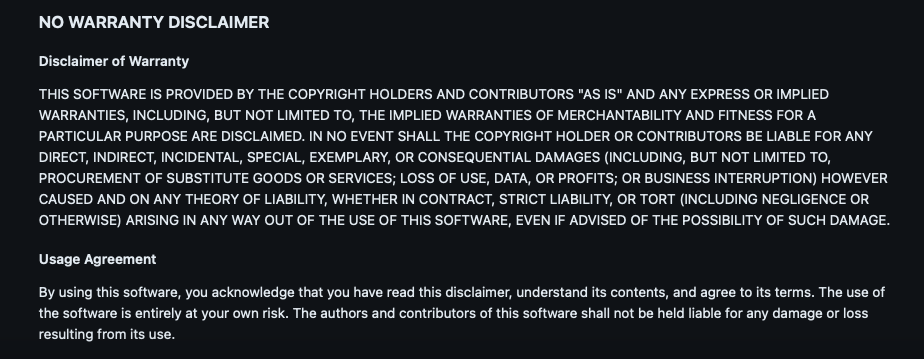

## Prompting RavenV2 -- Weather API Example

Let's use a few API functions to show the purpose (and power) of function calling!

### Defining Functions

Let's define some helpful functions for RavenV2. In this cell, we will define two functions -- a function to get a weather in a Latitude and Longitude, and a function to convert human-readable city names to the coordinates.

In [ ]:
import requests
def get_weather_data(coordinates):
    """
    Fetches weather data from the Open-Meteo API for the given latitude and longitude.

    Args:
    coordinates (tuple): The latitude of the location.

    Returns:
    float: The current temperature in the coordinates you've asked for
    """
    latitude, longitude = coordinates
    base_url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "current": "temperature_2m,wind_speed_10m",
        "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m"
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        print (f"""Temperature in C: {response.json()["current"]["temperature_2m"]}""")
    else:
        return {"error": "Failed to fetch data, status code: {}".format(response.status_code)}


You'll notice that this API requires latitude and longitude, which is a bit hard for users to provide (or for LLMs to know). Let's add a new function that allows easy conversion.

In [ ]:
def get_coordinates_from_city(city_name):
    """
    Fetches the latitude and longitude of a given city name using the Maps.co Geocoding API.

    Args:
    city_name (str): The name of the city.

    Returns:
    tuple: The latitude and longitude of the city.
    """
    base_url = "https://geocode.maps.co/search"
    params = {"q": city_name}

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            # Assuming the first result is the most relevant
            return data[0]["lat"], data[0]["lon"]
        else:
            return {"error": "No data found for the given city name."}
    else:
        return {"error": "Failed to fetch data, status code: {}".format(response.status_code)}


### Asking Raven

Great! Now, let's ask Raven to use these tools to answer user questions.

First, let's provide the functions to the model.

Please note that the way you provide this is by providing the "Function:" header, the function prototype, and the associated docstring as seen below.

In [ ]:
RAVEN_PROMPT = \
'''
Function:
def get_weather_data(coordinates):
    """
    Fetches weather data from the Open-Meteo API for the given latitude and longitude.

    Args:
    coordinates (tuple): The latitude of the location.

    Returns:
    float: The current temperature in the coordinates you've asked for
    """

Function:
def get_coordinates_from_city(city_name):
    """
    Fetches the latitude and longitude of a given city name using the Maps.co Geocoding API.

    Args:
    city_name (str): The name of the city.

    Returns:
    tuple: The latitude and longitude of the city.
    """

User Query: {query}<human_end>
'''

Let's provide Raven a question!

In [ ]:
QUESTION = "Whats's the weather like in Seattle right now?"

Now, let's prompt Raven!

In [ ]:
# Now, let's prompt Raven!
API_URL = "https://rjmy54al17scvxjr.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
        "Content-Type": "application/json"
}
def query(payload):
	"""
	Sends a payload to a TGI endpoint.
	"""
	import requests
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

def query_raven(prompt):
	"""
	This function sends a request to the TGI endpoint to get Raven's function call.
	This will not generate Raven's justification and reasoning for the call, to save on latency.
	"""
	import requests
	output = query({
		"inputs": prompt,
		"parameters" : {"temperature" : 0.001, "stop" : ["<bot_end>"], "do_sample" : False, "max_new_tokens" : 2000}})
	call = output[0]["generated_text"].replace("Call:", "").strip()
	return call

def query_raven_with_reasoning(prompt):
	"""
	This function sends a request to the TGI endpoint to get Raven's function call AND justification for the call
	"""
	import requests
	output = query({
		"inputs": prompt,
		"parameters" : {"temperature" : 0.001, "do_sample" : False, "max_new_tokens" : 2000}})
	call = output[0]["generated_text"].replace("Call:", "").strip()
	return call

In this cell, we can see Raven use the tools provided to it to give the User's query an answer.

In [ ]:
my_question = RAVEN_PROMPT.format(query = QUESTION)
raven_call = query_raven(my_question)
print (f"Raven's Call: {raven_call}")

Raven's Call: get_weather_data(coordinates=get_coordinates_from_city(city_name='Seattle'))


Great! Now, let's execute the call to actually use the APIs!

In [ ]:
exec(raven_call)

Temperature in C: 5.8


Awesome!! Seems it works :)

Raven can also continue the generation, allowing us to get a justification for the generated call.

In [ ]:
my_question = RAVEN_PROMPT.format(query = QUESTION)
raven_call = query_raven_with_reasoning(my_question)
print (f"Raven's Call: {raven_call}")

Raven's Call: get_weather_data(coordinates=get_coordinates_from_city(city_name='Seattle')) 
Thought: The function call `get_weather_data(coordinates=get_coordinates_from_city(city_name='Seattle'))` answers the question "What's the weather like in Seattle right now?" by following these steps:

1. `get_coordinates_from_city(city_name='Seattle')`: This function call fetches the latitude and longitude of the city "Seattle" using the Maps.co Geocoding API.
2. `get_weather_data(coordinates=...)`: This function call fetches the current weather data for the coordinates returned by the previous function call.

Therefore, the function call `get_weather_data(coordinates=get_coordinates_from_city(city_name='Seattle'))` answers the question "What's the weather like in Seattle right now?" by first fetching the coordinates of the city "Seattle" and then fetching the current weather data for those coordinates.


## Try Your Own!!

Please feel free to edit the functions provided in this prompt with your own, and give it a try!

### Endpoint
First, let's define the endpoint specifics (including the URL to query Raven). Please do not change these, as these are more of utilities that you can use to send prompts to Raven and receive Raven's completions.

In [ ]:
API_URL = "https://rjmy54al17scvxjr.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
        "Content-Type": "application/json"
}
def query(payload):
	"""
	Sends a payload to a TGI endpoint.
	"""
	import requests
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

def query_raven(prompt):
	"""
	This function sends a request to the TGI endpoint to get Raven's function call.
	This will not generate Raven's justification and reasoning for the call, to save on latency.
	"""
	import requests
	output = query({
		"inputs": prompt,
		"parameters" : {"temperature" : 0.001, "stop" : ["<bot_end>"], "do_sample" : False, "max_new_tokens" : 2000}})
	call = output[0]["generated_text"].replace("Call:", "").strip()
	return call

def query_raven_with_reasoning(prompt):
	"""
	This function sends a request to the TGI endpoint to get Raven's function call AND justification for the call
	"""
	import requests
	output = query({
		"inputs": prompt,
		"parameters" : {"temperature" : 0.001, "do_sample" : False, "max_new_tokens" : 2000}})
	call = output[0]["generated_text"].replace("Call:", "").strip()
	return call

### Now, Let's Run Your Functions!

Let's provide your functions to Raven and generate a call!

In this cell, please feel free to edit the functions, the doc strings, and the arguments as you see fit! You're also welcome to edit the user query/question!

In [ ]:
RAVEN_PROMPT = \
'''
Function:
def get_weather_data(coordinates):
    """
    Fetches weather data from the Open-Meteo API for the given latitude and longitude.

    Args:
    coordinates (tuple): The latitude of the location.

    Returns:
    float: The current temperature in the coordinates you've asked for
    """

Function:
def get_coordinates_from_city(city_name):
    """
    Fetches the latitude and longitude of a given city name using the Maps.co Geocoding API.

    Args:
    city_name (str): The name of the city.

    Returns:
    tuple: The latitude and longitude of the city.
    """

User Query: {query}<human_end>
'''

QUESTION = "Whats's the weather like in Seattle right now?"
my_question = RAVEN_PROMPT.format(query = QUESTION)

Now that we've constructed the question and the list of tools/functions, let's send it over to Raven!

In [ ]:
raven_call = query_raven(my_question)
print (f"Raven's Call: {raven_call}")

raven_call = query_raven_with_reasoning(my_question)
print (f"Raven's Reasoning: {raven_call}")

Raven's Call: get_weather_data(coordinates=get_coordinates_from_city(city_name='Seattle'))
Raven's Reasoning: get_weather_data(coordinates=get_coordinates_from_city(city_name='Seattle')) 
Thought: The function call `get_weather_data(coordinates=get_coordinates_from_city(city_name='Seattle'))` answers the question "What's the weather like in Seattle right now?" by following these steps:

1. `get_coordinates_from_city(city_name='Seattle')`: This function call fetches the latitude and longitude of the city "Seattle" using the Maps.co Geocoding API.
2. `get_weather_data(coordinates=...)`: This function call fetches the current weather data for the coordinates returned by the previous function call.

Therefore, the function call `get_weather_data(coordinates=get_coordinates_from_city(city_name='Seattle'))` answers the question "What's the weather like in Seattle right now?" by first fetching the coordinates of the city "Seattle" and then fetching the current weather data for those coordinat

## Advanced Prompting Guide

More advanced prompting strategies!

### Define the Endpoint For Raven

Please run these cells to get access to the endpoint!

In [ ]:
API_URL = "https://rjmy54al17scvxjr.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
        "Content-Type": "application/json"
}
def query(payload):
	"""
	Sends a payload to a TGI endpoint.
	"""
	import requests
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

def query_raven(prompt):
	"""
	This function sends a request to the TGI endpoint to get Raven's function call.
	This will not generate Raven's justification and reasoning for the call, to save on latency.
	"""
	import requests
	output = query({
		"inputs": prompt,
		"parameters" : {"temperature" : 0.001, "stop" : ["<bot_end>"], "do_sample" : False, "max_new_tokens" : 2000}})
	call = output[0]["generated_text"].replace("Call:", "").strip()
	return call

def query_raven_with_reasoning(prompt):
	"""
	This function sends a request to the TGI endpoint to get Raven's function call AND justification for the call
	"""
	import requests
	output = query({
		"inputs": prompt,
		"parameters" : {"temperature" : 0.001, "do_sample" : False, "max_new_tokens" : 2000}})
	call = output[0]["generated_text"].replace("Call:", "").strip()
	return call


### Parallel Calls
Raven is also capable of issuing Parallel Calls! Let's see a graph example!

In [ ]:
RAVEN_PROMPT = \
'''
Function:
def add_edge(u, v):
    """
    Adds an edge between node u and node v in the graph. Make sure to create a graph first by calling create_new_graph!

    Args:
      u (str): Node name as string
      v (str): Node name as string
    """

Function:
def is_two_nodes_connected(u, v):
    """
    Answers if two nodes are connected.
    """

User Query: Emma is friends with Bob and Charlie, and Charlie is friends with Erik, and Erik is friends with Brian. Can you represent all of these relationship as a graph and answer if Emma is friends with Erik?<human_end>
'''
print (query_raven_with_reasoning(RAVEN_PROMPT))


add_edge(u='Emma', v='Bob'); add_edge(u='Emma', v='Charlie'); add_edge(u='Charlie', v='Erik'); add_edge(u='Erik', v='Brian'); is_two_nodes_connected(u='Emma', v='Erik'); 
Thought: The set of Python calls provided will directly answer the question because they perform the following operations:

1. `add_edge(u='Emma', v='Bob')`: This call adds an edge between the nodes "Emma" and "Bob" in the graph.
2. `add_edge(u='Emma', v='Charlie')`: This call adds an edge between the nodes "Emma" and "Charlie" in the graph.
3. `add_edge(u='Charlie', v='Erik')`: This call adds an edge between the nodes "Charlie" and "Erik" in the graph.
4. `add_edge(u='Erik', v='Brian')`: This call adds an edge between the nodes "Erik" and "Brian" in the graph.
5. `is_two_nodes_connected(u='Emma', v='Erik')`: This call checks if the nodes "Emma" and "Erik" are connected in the graph.

The `add_edge` calls will create the necessary edges in the graph to represent the relationships between the nodes. The `is_two_nodes_c

### Optional Arguments

Raven is also capable of handling optional arguments. You can provide it as follows:

In [ ]:
RAVEN_PROMPT = \
'''
Function:
def getWeather(city_name : str, use_celsius : bool = False):
"""
Gets weather for a specific city, and other associated attributes.

Args:
- city_name: The name of the city as a string.
- use_celsius (Optional): If set, returns the temperature in celsius. Otherwise, by default, returns in Farenheit.
"""

User Query: {query}<human_end>

'''

QUESTION = "Hey, what's the weather like in New York right now?"

raven_question = RAVEN_PROMPT.format(query=QUESTION)
print (query_raven(raven_question))


getWeather(city_name='New York')


Notice how the optional argument is NOT used. But, let's change the prompt a bit.

In [ ]:
QUESTION = "Respond in SI units and tell me what's the conditions like in Seattle right now?"
raven_question = RAVEN_PROMPT.format(query=QUESTION)
print (query_raven(raven_question))

getWeather(city_name='Seattle', use_celsius=True)


Notice how the optional argument is now used!

### Explanability

Raven is also capable of giving well reasoned explanations on *why* these function calls were issued. To save on inference speed, we set a stop criteria of `<bot_end>` to prevent Raven from issuing the explanation. But if required, we can set the stop criteria to </s> to fully capitalize on Raven's ability to reason to provide justifications for the calls.

In [ ]:
RAVEN_PROMPT = \
'''
Function:
def getWeather(city_name : str, use_celsius : bool = False):
"""
Gets weather for a specific city, and other associated attributes.

Args:
- city_name: The name of the city as a string.
- use_celsius (Optional): If set, returns the temperature in celsius. Otherwise, by default, returns in Farenheit.
"""

User Query: {query}<human_end>

'''

QUESTION = "Respond in SI units and tell me what's the conditions like in Seattle right now?"
raven_question = RAVEN_PROMPT.format(query=QUESTION)
print (query_raven_with_reasoning(raven_question))

getWeather(city_name='Seattle', use_celsius=True) 
Thought: The function call `getWeather(city_name='Seattle', use_celsius=True)` answers the question "What's the conditions like in Seattle right now?" because it retrieves the weather data for the city of Seattle and returns it in SI units (celsius).

Here's why:

1. The `city_name` parameter is set to `'Seattle'`, which specifies the city for which the weather data should be retrieved.
2. The `use_celsius` parameter is set to `True`, which tells the function to return the temperature in celsius instead of farenheit.
3. The function call `getWeather(city_name='Seattle', use_celsius=True)` retrieves the weather data for the city of Seattle and returns it in celsius.

Therefore, the function call `getWeather(city_name='Seattle', use_celsius=True)` answers the question "What's the conditions like in Seattle right now?" by retrieving the weather data for the city of Seattle and returning it in SI units (celsius).
